Import packages and libraries

In [48]:
import tensorflow as tf
import os
import keras
import numpy as np
import easygdf
import mne
import json
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import get_data
from earlystopclass import EarlyStopAtAccuracy
from ipynb.fs.full.data_preprocess import save_data_in_csv,get_all_info,get_event_position,save_data_in_array,combine_data_labels,interpolation,cropping,events_to_classes
from sklearn.model_selection import train_test_split
from colabcode import ColabCode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter


The network model

In [ ]:
# Define the squeeze excitation block function
def squeeze_excitation_block(inputs, r):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling1D()(inputs)
    se = layers.Dense(filters // r, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, filters))(se)
    out=inputs * se
    return out

# def SqueezeAndExcitation(inputs, ratio=8): 
#     b, _, _, c = inputs.shape 
#     x = GlobalAveragePooling2D()(inputs) 
#     x = Dense(c//ratio, activation="relu", use_bias=False)(x) 
#     x = Dense(c, activation="sigmoid", use_bias=False)(x) 
#     x = inputs * x 
#     return x 

# Set random seed for reproducibility
tf.random.set_seed(1234)

# Define input shape
input_shape = (1000,22)

# Define input layers for each branch
input_1 = tf.keras.Input(shape=input_shape)
input_2 = tf.keras.Input(shape=input_shape)
input_3 = tf.keras.Input(shape=input_shape)

# First Branch
x1 = tf.keras.layers.Conv1D(32, 20, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)


x1 = tf.keras.layers.Conv1D(32, 9, strides=2, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection1 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection1])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection2 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection2])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x1 = tf.keras.layers.Flatten()(x1)

# Second Branch
x2 = tf.keras.layers.Conv1D(32, 13, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)

x2 = tf.keras.layers.Conv1D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)
skip_connection3 = x2

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.add([x2, skip_connection3])############
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Dropout(0.5)(x2)

x2 = tf.keras.layers.Flatten()(x2)

# Third Branch
x3 = tf.keras.layers.Conv1D(32, 15, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(32, 10, strides=2, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)

x3 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(48, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Dropout(0.5)(x3)

x3 = tf.keras.layers.Flatten()(x3)

# Concatenate the outputs of three branches
merged = tf.keras.layers.concatenate([x1, x2, x3])


#fc1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
#fc2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(fc1)

# Dropout layer
x = tf.keras.layers.Dropout(0.5)(merged)

# Output layer
output = tf.keras.layers.Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=[input_1, input_2, input_3], outputs=output)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Combine data recorded from subjects with labels

In [ ]:
#get info of events' positions
positions_of_labels=get_event_position()

#save raw eeg data recorded from subjects in array
data_arrays=save_data_in_array()

#combine data features or samples with their actual labels
combined_data=combine_data_labels(data_arrays,positions_of_labels)


Seprate test data before perform any data augmentation

In [33]:
#Generate shuffled indices
indices = np.arange(len(combined_data))
np.random.shuffle(indices)

# Shuffle x_train and y_train using the shuffled indices
shuffled_combined_data = [combined_data[i] for i in indices]

#seprate 12 percent of data for testing the model
raw_train,raw_test =train_test_split(shuffled_combined_data, test_size=0.12, random_state=1)


Seprate labels from raw_train and raw_test

In [34]:

#seprate labels from feature data
raw_x_train,raw_y_train = zip(*raw_train)
x_test,y_test = zip(*raw_test)

#convert type of array to numpy array
raw_x_train=np.array(raw_x_train)
raw_y_train=np.array(raw_y_train)

x_test=np.array(x_test)
y_test=np.array(y_test)

#change shape of y_test and y_train beacuse this is better shape more practical and 
raw_y_train = raw_y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


Interpolation

In [35]:
#perform interpolation operation and increase the size of matrices of each samples
interpolated_raw_x_train=interpolation(raw_x_train)

Cropping(extract new data from the primary data)

In [36]:
#perform cropping operation to increase the size of the data by 6 times
cropped_segments,segment_labels=cropping(interpolated_raw_x_train,raw_y_train)

Concatenate new data to primary data

In [37]:

#concatenate new created data from cropping operation to primary data
x_train = np.concatenate((raw_x_train, cropped_segments), axis=0)
y_train = np.concatenate((raw_y_train, segment_labels), axis=0)


# shuffle x_train and y_train using the shuffled indices
new_indices = np.arange(len(x_train))
np.random.shuffle(new_indices)

x_train = x_train[new_indices]
y_train = y_train[new_indices]

Change events' number to 0-3 classes

In [38]:
#cahnge events' number to 0-3 classes for y test/train
y_test=events_to_classes(y_test)
y_train=events_to_classes(y_train)
    

Split train data to train and validation

In [39]:
# Split the training data into training and cross-validation sets
x_train, x_cv , y_train, y_cv =train_test_split(x_train, y_train, test_size=0.10, random_state=1)


Train the model

Epoch 1/60
225/225 [==============================] - 65s 224ms/step - loss: 5.9362 - accuracy: 0.3191 - val_loss: 4.7186 - val_accuracy: 0.4787
Epoch 2/60
225/225 [==============================] - 51s 225ms/step - loss: 4.1846 - accuracy: 0.4629 - val_loss: 3.4418 - val_accuracy: 0.5489
Epoch 3/60
225/225 [==============================] - 51s 227ms/step - loss: 2.9787 - accuracy: 0.5615 - val_loss: 2.5122 - val_accuracy: 0.6059
Epoch 4/60
225/225 [==============================] - 50s 224ms/step - loss: 2.2023 - accuracy: 0.6170 - val_loss: 1.9407 - val_accuracy: 0.6328
Epoch 5/60
225/225 [==============================] - 51s 227ms/step - loss: 1.6697 - accuracy: 0.6727 - val_loss: 1.5427 - val_accuracy: 0.6554
Epoch 6/60
225/225 [==============================] - 53s 234ms/step - loss: 1.3418 - accuracy: 0.7056 - val_loss: 1.2165 - val_accuracy: 0.7256
Epoch 7/60
225/225 [==============================] - 51s 225ms/step - loss: 1.1169 - accuracy: 0.7390 - val_loss: 1.4383 - val_ac

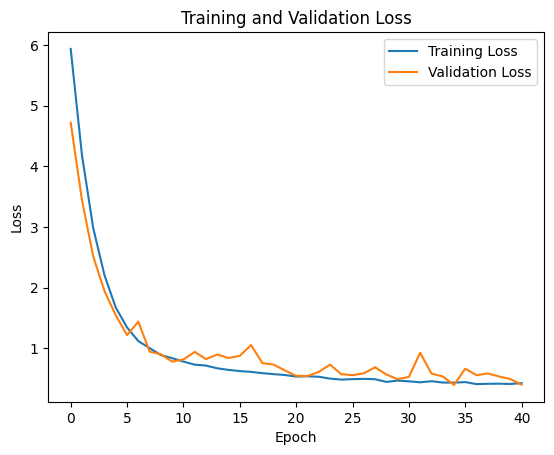

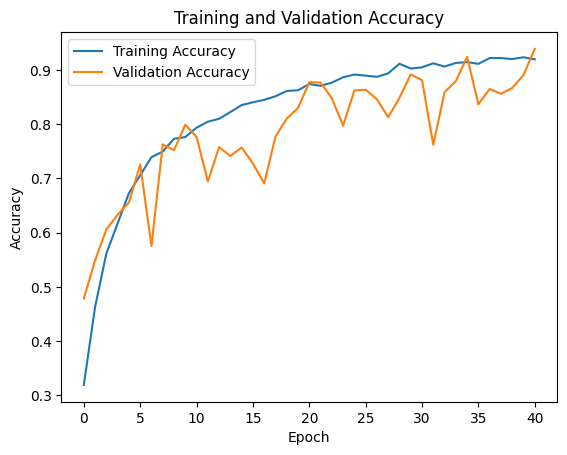

In [40]:
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
early_stopping = EarlyStopAtAccuracy(monitor='val_accuracy', target_accuracy=0.93, patience=0, verbose=1, mode='max')

# Train the model
history = model.fit(
    [x_train, x_train, x_train], y_train,
    epochs=60,
    batch_size=64,
    validation_data=([x_cv, x_cv, x_cv], y_cv),
    callbacks=[early_stopping]
)

# Plot training and validation loss.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Evaluate the model

In [41]:
def test_cropping(interpolated_x_test,old_x_test):
    # Initialize empty lists to store cropped segments and corresponding labels
    increased_x_test = []
    # Iterate over each sample
    for sample_idx in range(interpolated_x_test.shape[0]):
        # Get the EEG data for the current sample
        sample_data = interpolated_x_test[sample_idx, :, :]
        # Calculate the number of segments
        num_segments = (sample_data.shape[0] - 1000) // 10 + 1

        temp=[]
        temp.append(old_x_test[sample_idx])
        # Iterate over each segment
        for segment_idx in range(num_segments):
            # Calculate start index of the segment
            start_idx = segment_idx * 10
            # Extract the segment
            segment = sample_data[start_idx:start_idx + 1000, :]
            # Append the segment to the list of cropped segments
            temp.append(segment)

        increased_x_test.append(temp)
    # Convert the lists to numpy arrays
    increased_x_test = np.array(increased_x_test)
    

    return increased_x_test

In [42]:
original_x_test=x_test
original_y_test=y_test

interpolated_x_test=interpolation(x_test)
increased_x_test=test_cropping(interpolated_x_test,original_x_test)


In [43]:
final_y_pred=[]
for i in range(increased_x_test.shape[0]):
    y_predict=model.predict([increased_x_test[i], increased_x_test[i], increased_x_test[i]])
    y_pred_labels = np.argmax(y_predict, axis=1)
    counter = Counter(y_pred_labels)
    most_common = counter.most_common(1)
    final_y_pred.append(most_common[0][0])



1/1 [==============================] - 0s 30ms/step


In [44]:
final_y_pred=np.array(final_y_pred)##
final_y_pred=final_y_pred.reshape(-1,1)
final_y_pred = final_y_pred.astype(np.int32)


In [45]:
f1 = f1_score(y_test, final_y_pred, average='weighted')
print(f'Test F1 Score: {f1}')

Test F1 Score: 0.7264175568789091


In [49]:
test_accuracy = accuracy_score(y_test, final_y_pred)
print(f'Test Accuracy: {test_accuracy}')

Test Accuracy: 0.7275641025641025


In [ ]:
# Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate([x_test, x_test, x_test], y_test, verbose=0)

# # Predict labels for the test set
# y_pred = model.predict([x_test, x_test, x_test])

# # Convert predicted probabilities to labels
# y_pred_labels = np.argmax(y_pred, axis=1)

# # Calculate F1 score
# f1 = f1_score(y_test, y_pred_labels, average='weighted')

# print(f'Test Loss: {test_loss}')
# print(f'Test Accuracy: {test_accuracy}')
# print(f'Test F1 Score: {f1}')